In [1]:
# Import the libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,accuracy_score
from sklearn.neighbors import KNeighborsClassifier


# Read the dataset
data = pd.read_csv("creditcard.csv")

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [3]:
#Removing the time column since it would not help in model training
data.drop(["Time"],axis=1,inplace = True)

In [4]:
# Lets check the missing values in case any
data.isnull().sum()

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [5]:
# Correlation of variables with the target class.
corr = data.corr()
corr["Class"]

V1       -0.101347
V2        0.091289
V3       -0.192961
V4        0.133447
V5       -0.094974
V6       -0.043643
V7       -0.187257
V8        0.019875
V9       -0.097733
V10      -0.216883
V11       0.154876
V12      -0.260593
V13      -0.004570
V14      -0.302544
V15      -0.004223
V16      -0.196539
V17      -0.326481
V18      -0.111485
V19       0.034783
V20       0.020090
V21       0.040413
V22       0.000805
V23      -0.002685
V24      -0.007221
V25       0.003308
V26       0.004455
V27       0.017580
V28       0.009536
Amount    0.005632
Class     1.000000
Name: Class, dtype: float64

In [6]:
# Removing the variables which can affect the output stream
#These are features either are too negatively correlated with the target or too much positive with target(may surpress other features)
COL=["V3","V10","V12","V14","V16","V17","V18"]
data.drop(COL,axis=1,inplace=True)

In [7]:
# Lets normalise the amount column
# Need not perform scaling of other features since all values have been scaled because of the PCA applied before the data was released
from sklearn.preprocessing import StandardScaler
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Amount'],axis=1)

In [8]:
#Checking the ratio of classes with respect to each other 
data["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [9]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = data.sample(frac=1)

# NO of fraud instances :: 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,V1,V2,V4,V5,V6,V7,V8,V9,V11,V13,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
198099,1.845581,-0.695475,-0.044429,0.016017,1.329971,-0.933789,0.480372,1.518776,-0.382517,-0.020482,...,0.262245,1.051784,0.242267,-0.306597,-0.379961,0.191601,0.061163,-0.044915,0,-0.265471
11841,-15.271362,8.326581,11.885313,-8.721334,-2.324307,-16.196419,0.512882,-6.333685,9.939820,0.716034,...,-2.356896,1.068019,1.085617,-1.039797,-0.182006,0.649921,2.149247,-1.406811,1,-0.349231
175721,2.014027,-0.043557,0.343112,-0.299902,-1.210573,0.070359,-0.274899,0.715838,-0.511497,0.111425,...,-0.419915,-1.206797,0.497671,-0.043760,-0.517003,-0.882409,0.000111,-0.034275,0,-0.301454
261925,-2.783865,1.596824,2.512986,-1.446749,-0.828496,-0.732262,-0.203329,-0.347046,1.966123,0.506574,...,0.203563,0.293268,0.199568,0.146868,0.163602,-0.624085,-1.333100,0.428634,1,0.270472
234705,-2.219219,0.727831,5.924850,3.932464,-3.085984,-1.677870,0.865075,-3.177260,3.693174,-1.718591,...,0.417472,-0.817343,-0.028752,0.025723,-0.825835,-0.013089,0.413291,-0.131387,1,-0.353229


In [10]:
# Lets split the data into features and target
features = new_df.drop(["Class"],axis =1)
target = new_df["Class"]
from sklearn.model_selection import train_test_split

# Splitting the data into train and test
X_train,X_test, Y_train,Y_test = train_test_split(features, target, test_size = .3, random_state =5)

<h1> GRID SEARCH CV </h1>
Lets apply the grid search in other to obtain our the best hyperparamter for our models 


In [11]:
# Logistic Regression 
# Solver is liblinear since its supports both l1 and l2 penalities
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],"solver" :['liblinear']}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, Y_train)
# We automatically get the logistic regression with the best parameters.

print(grid_log_reg.best_estimator_)

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, Y_train)
# KNears best estimator
print(grid_knears.best_estimator_)

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, Y_train)

# SVC best estimator

print(grid_svc.best_estimator_)

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, Y_train)

# tree best estimator
print(grid_tree.best_estimator_)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
SVC(C=0.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
    

<h1>LETS Train those models</h1>
We would be deploying cross validation score in order to get a much better result

In [16]:

k = KFold(n_splits = 5)
classifiers = {
    'Logistic Regression':grid_log_reg.best_estimator_,
               'Support Vector Machine' : grid_svc.best_estimator_,
               'Random Forest Classifier': RandomForestClassifier(),
               'Decision Tree Algorithm':grid_tree.best_estimator_,
               'KNN':grid_knears.best_estimator_
              }
def model(m):
    for i in m:
        print(i)
        print('-'*100)
        m[i].fit(X_train,Y_train.values.ravel())
        prediction = m[i].predict(X_test)
        print('Classification Report')        
        cr = classification_report(Y_test,prediction,output_dict=True)
        print(pd.DataFrame(cr).transpose())
        print('='*100)
        accuracy = accuracy_score(Y_test.values.ravel(),prediction)
        print('Accuracy Score :  ',accuracy)
        print('='*100)
        print('Cross Validation Score')
        cv=cross_val_score(m[i],X_train,Y_train,cv=k,scoring='accuracy')
        print(cv.mean())
        print('-'*100)

In [17]:
model(classifiers)

Logistic Regression
----------------------------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score     support
0              0.910256  0.946667  0.928105  150.000000
1              0.942857  0.904110  0.923077  146.000000
accuracy       0.925676  0.925676  0.925676    0.925676
macro avg      0.926557  0.925388  0.925591  296.000000
weighted avg   0.926337  0.925676  0.925625  296.000000
Accuracy Score :   0.9256756756756757
Cross Validation Score
0.9186290066645508
----------------------------------------------------------------------------------------------------
Support Vector Machine
----------------------------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score     support
0              0.904459  0.946667  0.925081  150.000000
1              0.942446  0.897260  0.919298  146.000000
accuracy       0.922297  0

In [18]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import numpy as np
import matplotlib.pyplot as plt
def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Vatsal Tulshyan\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

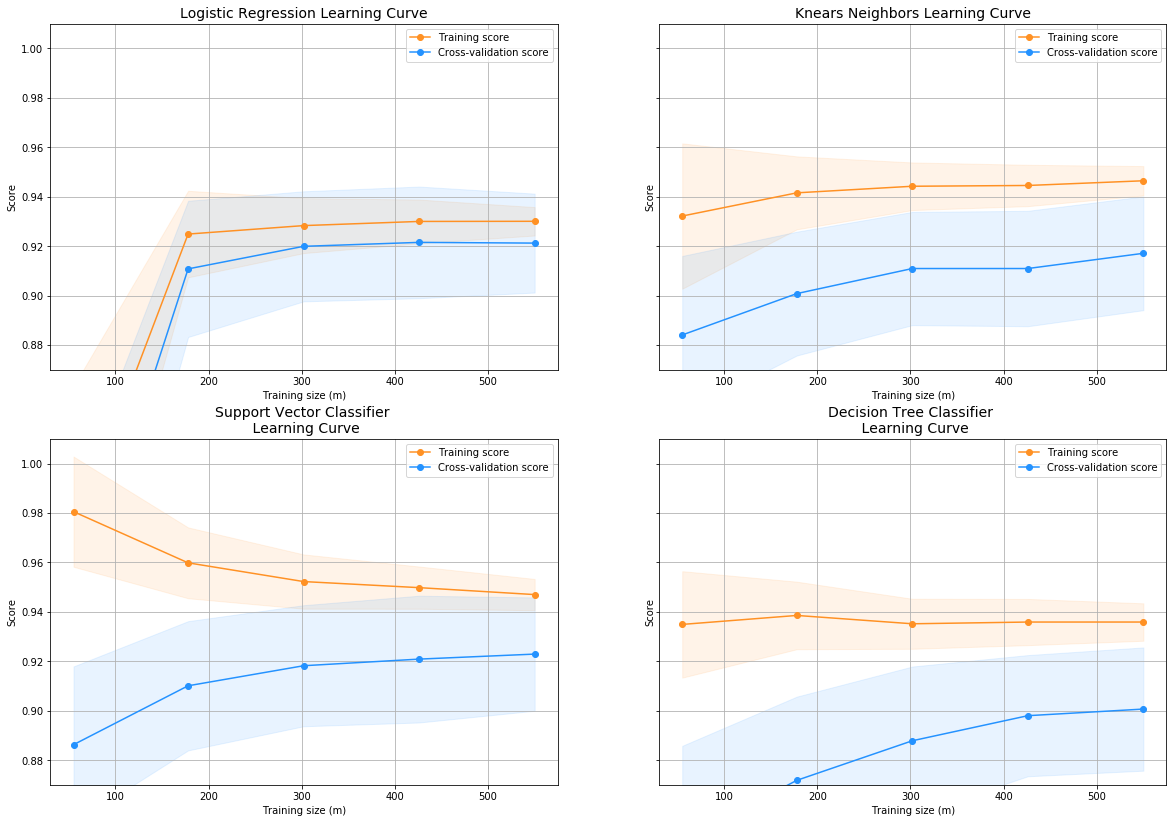

In [19]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(classifiers["Logistic Regression"],classifiers["KNN"], classifiers["Support Vector Machine"], classifiers["Decision Tree Algorithm"], X_train, Y_train, (0.87, 1.01), cv=cv, n_jobs=4)

Therefore we observe that KNN is a bit overfitted then the other models and Logistic Regression performs the best.

<h1> ROC_AUC_SCORE </h1>

In [20]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(classifiers["Logistic Regression"], X_train, Y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(classifiers["KNN"], X_train, Y_train, cv=5)

svc_pred = cross_val_predict(classifiers["Support Vector Machine"], X_train, Y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(classifiers["Decision Tree Algorithm"], X_train, Y_train, cv=5)
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(Y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(Y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(Y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(Y_train, tree_pred))

Logistic Regression:  0.957205151607342
KNears Neighbors:  0.9173596322212081
Support Vector Classifier:  0.9571459960112225
Decision Tree Classifier:  0.9042693438799311


<h1> Lets Train Neural Networks </h1>

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

#Size of the input of the input layer
n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.02)),
    Dense(2, activation='softmax') #2 neurons because we have 2 output classes 
])

In [14]:
undersample_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 22)                506       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                736       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 1,308
Trainable params: 1,308
Non-trainable params: 0
_________________________________________________________________


In [16]:
#using sparse_categorial because there is a lot of sparse of values in the target so it is preferred to use this loss
# using accuracy since it is classification problem 
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
#Spliting into train, Dev set and test set
# Train = 60% Valid = 30% Test = 1% on original dataset 
X= data.drop(["Class"],axis = 1)
Y = data["Class"]
org_x_train_f,org_x_test,org_y_train_f,org_y_test = train_test_split(X,Y,test_size = .1,random_state = 1)
org_x_train,org_x_valid,org_y_train,org_y_valid = train_test_split(org_x_train_f,org_y_train_f,test_size = .3,random_state = 1)

In [21]:
# Using random shuffling in the dataset while fitting
history=undersample_model.fit(X_train, Y_train, batch_size=64, epochs=40, shuffle=True, verbose=2,validation_data = (org_x_valid,org_y_valid))

Epoch 1/40
11/11 - 1s - loss: 0.4298 - accuracy: 0.9331 - val_loss: 0.4599 - val_accuracy: 0.9297
Epoch 2/40
11/11 - 1s - loss: 0.4164 - accuracy: 0.9375 - val_loss: 0.4426 - val_accuracy: 0.9330
Epoch 3/40
11/11 - 1s - loss: 0.4031 - accuracy: 0.9375 - val_loss: 0.4309 - val_accuracy: 0.9338
Epoch 4/40
11/11 - 1s - loss: 0.3903 - accuracy: 0.9404 - val_loss: 0.4261 - val_accuracy: 0.9321
Epoch 5/40
11/11 - 1s - loss: 0.3791 - accuracy: 0.9419 - val_loss: 0.4143 - val_accuracy: 0.9339
Epoch 6/40
11/11 - 1s - loss: 0.3681 - accuracy: 0.9491 - val_loss: 0.4023 - val_accuracy: 0.9361
Epoch 7/40
11/11 - 1s - loss: 0.3577 - accuracy: 0.9520 - val_loss: 0.3804 - val_accuracy: 0.9427
Epoch 8/40
11/11 - 1s - loss: 0.3477 - accuracy: 0.9506 - val_loss: 0.3805 - val_accuracy: 0.9393
Epoch 9/40
11/11 - 1s - loss: 0.3383 - accuracy: 0.9477 - val_loss: 0.3799 - val_accuracy: 0.9368
Epoch 10/40
11/11 - 1s - loss: 0.3296 - accuracy: 0.9506 - val_loss: 0.3659 - val_accuracy: 0.9402
Epoch 11/40
11/11 -

In [22]:
#Lets check out the weights and biases in each layer
for i in range(3):
    print('Layer',i+1)
    print("-"*10)
    hidden_layer  = undersample_model.layers[i]
    weights,biases = hidden_layer.get_weights()
    print('Weights')
    print(weights)
    print("Weight shape",weights.shape)
    print("*"*10)
    print('Bias')
    print(biases)
    print("Bias shape",biases.shape)
    print("="*10)

Layer 1
----------
Weights
[[-0.3315032   0.19884455  0.24800998  0.00125653  0.18663765 -0.11961709
  -0.22069709 -0.16000958 -0.138472    0.14848784 -0.13599226 -0.14491107
  -0.13568947 -0.113422   -0.3525066   0.13597412  0.23261246  0.33832982
   0.30424294 -0.506586    0.39025608 -0.35053128]
 [ 0.12444002  0.23477046  0.2728309  -0.1650032   0.1038542   0.08907411
   0.14808899 -0.15688214  0.12437005  0.14656521 -0.31310743 -0.31064567
   0.3425692   0.339109   -0.18276906 -0.00293426  0.4198335   0.19748795
  -0.09589107  0.36351565 -0.21834287  0.13672459]
 [-0.1194565   0.28332725 -0.03251269 -0.0027399   0.27197817 -0.25832102
   0.1124176   0.07357594 -0.05074754  0.42128858 -0.49079522  0.07986705
   0.05743928  0.2037213   0.44782665  0.0183568   0.28966892 -0.43832797
   0.5097004  -0.531312   -0.3058743   0.02950264]
 [-0.251974   -0.15956657  0.16057862 -0.16922829  0.19392371 -0.2312285
  -0.00740698  0.04165154 -0.27738655  0.37521568  0.14998451  0.16259107
  -0.23

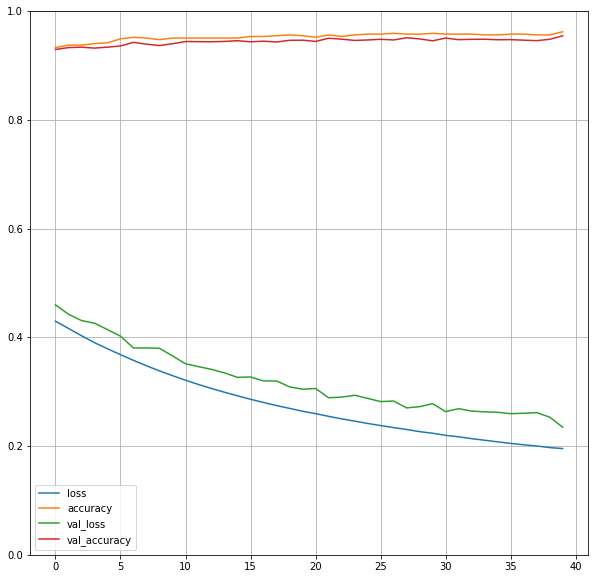

In [23]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(10,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

The results are quite promising since the loss is decreasing and overfitting doesn't seems to occur

In [24]:
# Evaluation on test test 
acc=undersample_model.evaluate(org_x_test,org_y_test)
print('Loss : {} ,Accuracy : {}'.format(acc[0],acc[1]*100))

891/891 [==============================] - 1s 739us/step - loss: 0.2396 - accuracy: 0.95430s - loss: 0.2390 
Loss : 0.23964202404022217 ,Accuracy : 95.43204307556152


## DEPLOYMENT

In [26]:
tf.saved_model.save(undersample_model,"saved_model/1/")

INFO:tensorflow:Assets written to: saved_model/1/assets


In [12]:
import json
a = np.array(X_test) 
input_data_json = json.dumps({
    "signature_name":"serving_default",
    "instances":a.tolist()
})

In [ ]:
#Deploy to Local Server
import requests
SERVER_URL = "http://localhost:8501/v1/models/saved_model:predict"
response = requests.post(SERVER_URL,data=input_data_json)
response.raise_for_status()
response = response.json()

In [17]:
#Deploy to Remote Server
import requests
SERVER_URL = "http://saved-model1.herokuapp.com/v1/models/saved_model:predict"
response = requests.post(SERVER_URL,data=input_data_json)
response.raise_for_status()
response = response.json()

In [18]:
y_prob = np.array(response["predictions"])

In [20]:
#We have two colums showing 
y_prob

array([[9.43670809e-01, 5.63291423e-02],
       [6.42695581e-04, 9.99357283e-01],
       [7.51670301e-01, 2.48329729e-01],
       [8.02332461e-01, 1.97667554e-01],
       [6.47768736e-01, 3.52231234e-01],
       [9.34807584e-03, 9.90651965e-01],
       [1.12201542e-01, 8.87798488e-01],
       [5.80785573e-01, 4.19214368e-01],
       [2.87550855e-02, 9.71244872e-01],
       [1.61387593e-01, 8.38612378e-01],
       [1.73494611e-02, 9.82650578e-01],
       [9.93606806e-01, 6.39321096e-03],
       [9.77948785e-01, 2.20512077e-02],
       [9.62185442e-01, 3.78144979e-02],
       [9.91601527e-01, 8.39848258e-03],
       [8.59559655e-01, 1.40440285e-01],
       [9.97518539e-01, 2.48144544e-03],
       [1.96178500e-02, 9.80382085e-01],
       [9.55056965e-01, 4.49430235e-02],
       [7.84523845e-01, 2.15476170e-01],
       [8.53933035e-10, 1.00000000e+00],
       [3.12961092e-05, 9.99968648e-01],
       [9.39711779e-02, 9.06028807e-01],
       [6.45927386e-04, 9.99354064e-01],
       [2.810209